Let's actually take a look at our dicoms and see what we can glean from the distribution of information across scans.

First we'll need to actually extract the information we want into a dataframe

In [109]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
from pydicom import dcmread

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [3]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [4]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [6]:
#transforms all slices in a scan in hounsfield units 
def ct_transformed(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [13]:
one_scan = ct_transformed(dcm_sort(train_path.ls()[19]), 0)
len(one_scan), one_scan[20:30].shape

(64, (10, 512, 512))

In [14]:
ten_slices = one_scan[20:30]

In [23]:
def plot_slices(slices, rows, columns, figsize=(20,10)):
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    for n in range(rows):
        for m in range(columns):
            ax[n, m].imshow(ten_slices[n*5 + m])

In [25]:
train_path.ls()

(#176) [Path('train/ID00232637202260377586117'),Path('train/ID00134637202223873059688'),Path('train/ID00093637202205278167493'),Path('train/ID00307637202282126172865'),Path('train/ID00364637202296074419422'),Path('train/ID00172637202238316925179'),Path('train/ID00335637202286784464927'),Path('train/ID00213637202257692916109'),Path('train/ID00392637202302319160044'),Path('train/ID00030637202181211009029')...]

Having to query into the dicom each time we want to extract out information is cumbersome -- let's just pull all the data from the dicoms we're interested in considering into a dataframe

In [27]:
%%time
scans = [dcm_sort(folder) for folder in train_path.ls()]

CPU times: user 21.1 s, sys: 11.4 s, total: 32.4 s
Wall time: 45 s


In [33]:
#ok now we have 176 lists of dicoms inside of a list
len(scans)

176

Let's initialize a dataframe of the right size -- 176 rows by X number of columns -- let's remind ourselves what's in a dicom first

In [39]:
dcm = scans[0][0]
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.121598162386088989868087504905267208491
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.121598162386088989868087504905267208491
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'TOSHIBA'
(0008, 1090) M

Just showing how we'll create lists of values we're interested in - a list of lists -- which we can simply cast into a pandas dataframe when we're done

In [69]:
meow = len(scans[0])
meow

67

In [70]:
scan_info = [meow, dcm.Rows, dcm.Columns, dcm.SliceThickness,
             dcm.PixelSpacing[0], dcm.PixelSpacing[1],
             dcm.Manufacturer]

In [73]:
scan_info

[67, 512, 512, "5.0", "0.683", "0.683", 'TOSHIBA']

In [93]:
%%time
holder = []
for dcms in scans:
    slice_count = len(dcms)
    dcm = dcms[0]
    holder.append([slice_count, dcm.Rows, dcm.Columns, 
                   dcm.SliceThickness, dcm.PixelSpacing[0], 
                   dcm.PixelSpacing[1], dcm.Manufacturer])

CPU times: user 4.57 ms, sys: 240 µs, total: 4.81 ms
Wall time: 4.77 ms


In [94]:
len(holder), holder[0]

(176, [67, 512, 512, "5.0", "0.683", "0.683", 'TOSHIBA'])

In [126]:
metadata = pd.DataFrame(holder, columns=['num_slices', 'rows', 'columns', 
                              'slice_thickness', 'spacing_x', 
                              'spacing_y', 'manufacturer'])

In [108]:
type(metadata['spacing_y'][0]), type(metadata['manufacturer'][0])

(numpy.float64, str)

Pandas did the work for us to cast things that look like numerical values as such! :)

We could of course create a function of the above and choose what values to pass, or set some defaults but allow for it to add additional values if desired -- it would also send it into the dataframe and return that

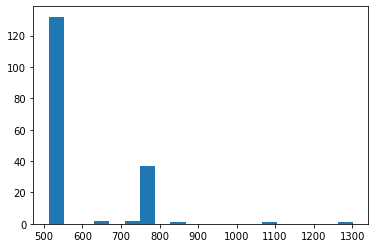

In [116]:
plt.hist(metadata['rows'], bins=20);

In [118]:
metadata['rows'].value_counts()

512     132
768      34
752       2
632       2
734       1
733       1
1100      1
843       1
1302      1
788       1
Name: rows, dtype: int64

In [119]:
metadata['columns'].value_counts()

512     132
768      34
888       7
632       2
1302      1
Name: columns, dtype: int64

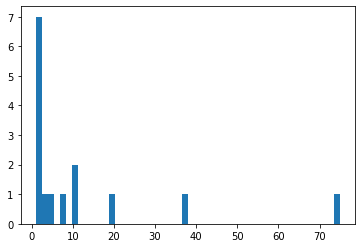

In [133]:
plt.hist(metadata['slice_thickness'].value_counts(), bins=50);

Now we know that some of our images don't have the same shape across both dimensions

The little noise below is simply checking if the spacing is the same in both direction. Since it returns true, we flip and it and sum the value. If it adds up to zero, that means everything matched up

In [124]:
(~(metadata['spacing_x'] == metadata['spacing_y'])).sum()

0

Let's also add some less obvious information

In [150]:
%%time
holder = []
for dcms in scans:
    slice_count = len(dcms)
    dcm = dcms[0]
    holder.append([slice_count, dcm.Rows, dcm.Columns, 
                   dcm.SliceThickness, dcm.PixelSpacing[0], 
                   dcm.PixelSpacing[1], dcm.Manufacturer,
                  dcm.KVP, dcm.ConvolutionKernel,
                  dcm.PatientPosition])
    
metadata = pd.DataFrame(holder, columns=['num_slices', 'rows', 'columns', 
                              'slice_thickness', 'spacing_x', 
                              'spacing_y', 'manufacturer',
                            'kvp', 'convolution_kernel',
                                        'patient_position'])

CPU times: user 20.4 ms, sys: 126 µs, total: 20.6 ms
Wall time: 20.3 ms


In [151]:
metadata

,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,manufacturer,kvp,convolution_kernel,patient_position
0,67,512,512,5.000,0.683000,0.683000,TOSHIBA,120.0,FC52,FFS
1,451,512,512,1.000,0.740234,0.740234,Philips,120.0,YC,HFS
2,37,512,512,1.000,0.880859,0.880859,SIEMENS,120.0,B60f,FFS
3,29,512,512,1.000,0.707031,0.707031,SIEMENS,110.0,B90s,HFS
4,33,512,512,1.000,0.712891,0.712891,SIEMENS,100.0,B50f,HFS
...,...,...,...,...,...,...,...,...,...,...
171,33,512,512,1.000,0.650391,0.650391,SIEMENS,120.0,B70s,FFP
172,32,512,512,1.000,0.656250,0.656250,SIEMENS,120.0,B50f,HFS
173,319,733,888,1.250,0.871094,0.871094,GE MEDICAL SYSTEMS,120.0,LUNG,FFS
174,521,512,512,0.625,0.677734,0.677734,GE MEDICAL SYSTEMS,120.0,LUNG,FFS


In [153]:
metadata['manufacturer'].value_counts()

SIEMENS                        74
GE MEDICAL SYSTEMS             45
Philips                        28
TOSHIBA                        26
PACSMATT                        1
PACSGEAR                        1
Hitachi Medical Corporation     1
Name: manufacturer, dtype: int64

In [155]:
#Peak kilo voltage output of xray generator used
metadata['kvp'].value_counts()

120.0    130
140.0     19
100.0     12
130.0     11
110.0      3
135.0      1
Name: kvp, dtype: int64

In [158]:
#convolution kernel used to reconstruct the data
metadata['convolution_kernel'].value_counts()

LUNG         18
B70f         17
B70s         16
BONEPLUS     13
B60f         10
BONE         10
L             9
B50f          8
B80s          8
C             8
FC86          6
FC52          5
STANDARD      4
B90s          4
FC51          4
FC01          4
YB            3
D             3
FC53          2
B80f          2
YC            2
B50s          2
FC30          2
B60s          2
B             1
[I50f, 3]     1
B40f          1
23            1
B41f          1
FC50          1
FC18          1
B31f          1
B30f          1
F             1
YD            1
DETAIL        1
CHST          1
FC11          1
Name: convolution_kernel, dtype: int64

In [160]:
metadata['patient_position'].value_counts()

HFS    85
FFS    82
FFP     7
HFP     2
Name: patient_position, dtype: int64